In [42]:
# install Kaggle
!pip install -q kaggle

In [43]:
# upload kaggle API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"protikmostafa","key":"59de96692a0e8e07db6abdcbdb3954a6"}'}

In [44]:
# create a kaggle folder
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [45]:
# copy kaggle.json to the folder
! cp kaggle.json ~/.kaggle/

In [46]:
# permission from json to act
! chmod 600 ~/.kaggle/kaggle.json

In [47]:
# list of all datasets in kaggle
! kaggle datasets list

ref                                                       title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                        Data Science Job Salaries                           7KB  2022-06-15 08:59:12          10813        346  1.0              
surajjha101/bigbasket-entire-product-list-28k-datapoints  BigBasket Entire Product List (~28K datapoints)     6MB  2022-06-22 12:51:18           3482        128  1.0              
zusmani/petrolgas-prices-worldwide                        Petrol/Gas Prices Worldwide                        10KB  2022-06-24 01:25:33           2890        124  1.0              
ramjasmaurya/1-gb-internet-price                          Internet Prices around 200+ countries in 2

In [48]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [49]:
! unzip titanic.zip

Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gender_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [50]:
import pandas as pd
import numpy as np

In [51]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### EDA for missing values

In [52]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [53]:
#df['Cabin_null'] = np.where(df['Cabin'].isnull(),1,0)

# Percentage of Cabin column being missing
(df['Cabin'].isnull().sum()/df.shape[0])*100

77.10437710437711

In [54]:
# Considering the fewer columns
df1= pd.read_csv('train.csv',usecols=['Survived','Age',"Fare"])

In [55]:
# Percentage of Missing Values per Column
df1.isnull().mean()

Survived    0.000000
Age         0.198653
Fare        0.000000
dtype: float64

#### Mean/Median/Mode Replacement

In [56]:
# Defining the function
def mmm_impute_nan(df1,variable,mean,median):
    df1[variable+"_mean"]=df1[variable].fillna(mean)
    df1[variable+"_median"]=df1[variable].fillna(median)

In [57]:
mean = df["Age"].mean()
median = df["Age"].median()

In [58]:
mmm_impute_nan(df1,'Age',mean,median)
# After Imputing
df1.isnull().sum()

Survived        0
Age           177
Fare            0
Age_mean        0
Age_median      0
dtype: int64

In [59]:
print(df1['Age'].std())
print(df1['Age_mean'].std())
print(df1['Age_median'].std())

14.526497332334042
13.002015226002882
13.019696550973201


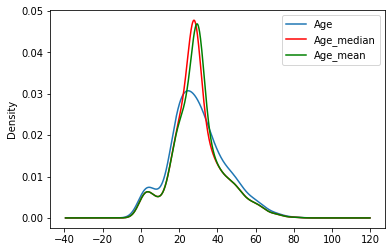

In [60]:
# looking at the KDE
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
df1['Age'].plot(kind = "kde", ax = ax)
df1.Age_median.plot(kind="kde", ax=ax, color = 'red')
df1.Age_mean.plot(kind="kde", ax=ax, color = 'green')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

# Obeservation
# 1. Distorted Variance

#### Random Sample Imputation

In [61]:
df2=pd.read_csv('train.csv', usecols=['Age', 'Survived', 'Fare'])
df2.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [62]:
df2.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

In [63]:
# Taking a sample from not null values
df2.Age.dropna().sample()

342    28.0
Name: Age, dtype: float64

In [64]:
df2.Age.dropna().sample(df.Age.isnull().sum())

694    60.0
833    23.0
247    24.0
106    21.0
102    21.0
       ... 
397    46.0
323    22.0
857    51.0
0      22.0
41     27.0
Name: Age, Length: 177, dtype: float64

In [65]:
def rsi_impute(df, variable, median):
    df[variable+"_median"] = df[variable].fillna(median)
    df[variable+"_rsi"] = df[variable]
    #Taking the Random Samples
    random_sample = df[variable].dropna().sample(df[variable].isnull().sum(), random_state = 123)
    # Saving the index of null values from original dataset
    random_sample.index = df[df[variable].isnull()].index
    # Replicating random_sample values to the dataset
    df.loc[df[variable].isnull(),variable+"_rsi"] = random_sample

In [66]:
rsi_impute(df2,'Age',median)
df2.isnull().sum()

Survived        0
Age           177
Fare            0
Age_median      0
Age_rsi         0
dtype: int64

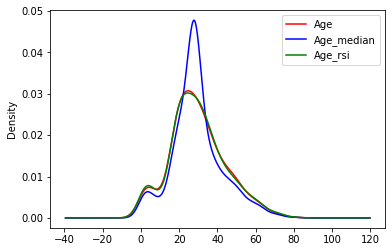

In [67]:
# Visualizing the variance
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df2['Age'].plot(kind = 'kde', color = 'r')
df2['Age_median'].plot(kind = 'kde', color = 'b')
df2['Age_rsi'].plot(kind = 'kde', color = 'g')
ax.legend()

# Observation
# 1. Low Variance with Random Sample Imputation with original data

#### Capturing NaN Values with new features

In [68]:
df3=pd.read_csv('train.csv', usecols=['Age', 'Survived', 'Fare'])
df3.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [69]:
import numpy as np
df3['Age_nan'] = np.where(df3['Age'].isnull(),1,0)
df3.Age_nan

0      0
1      0
2      0
3      0
4      0
      ..
886    0
887    0
888    1
889    0
890    0
Name: Age_nan, Length: 891, dtype: int64

In [70]:
df3['Age'].fillna(df.Age.median(), inplace = True)

In [71]:
df3.head(15)

,Survived,Age,Fare,Age_nan
0,0,22.0,7.2500,0
1,1,38.0,71.2833,0
2,1,26.0,7.9250,0
3,1,35.0,53.1000,0
4,0,35.0,8.0500,0
5,0,28.0,8.4583,1
6,0,54.0,51.8625,0
7,0,2.0,21.0750,0
8,1,27.0,11.1333,0
9,1,14.0,30.0708,0


#### End of Distribution Imputation

In [72]:
df4=pd.read_csv('train.csv', usecols=['Age', 'Survived', 'Fare'])
df4.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


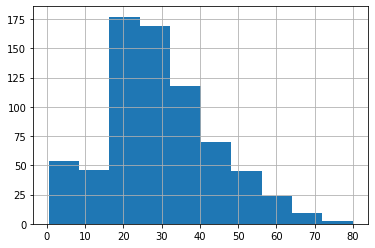

In [73]:
df.Age.hist()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


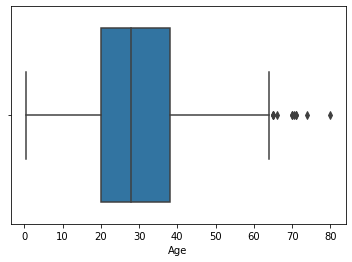

In [74]:
import seaborn as sns
sns.boxplot('Age', data = df4)

# Observation
# Outliers in the data

In [75]:
def eod_impute(df, variable, median, eodVal):
    df[variable+"_median"] = df[variable].fillna(median)
    df[variable+"_eod"] = df[variable].fillna(eodVal)

In [76]:
eodVal = df.Age.mean()+3*df.Age.std()
eodVal

73.27860964406094

In [77]:
eod_impute(df4,'Age', median, eodVal)
df4.head()

,Survived,Age,Fare,Age_median,Age_eod
0,0,22.0,7.2500,22.0,22.0
1,1,38.0,71.2833,38.0,38.0
2,1,26.0,7.9250,26.0,26.0
3,1,35.0,53.1000,35.0,35.0
4,0,35.0,8.0500,35.0,35.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f80e93cd1d0>],
      dtype=object)

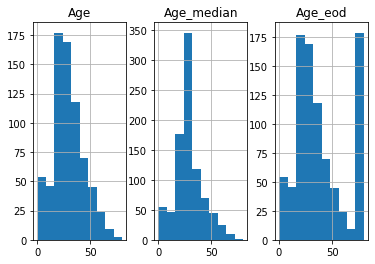

In [78]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3)
df4.hist('Age', ax = ax[0])
df4.hist('Age_median', ax = ax[1])
df4.hist('Age_eod', ax = ax[2])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


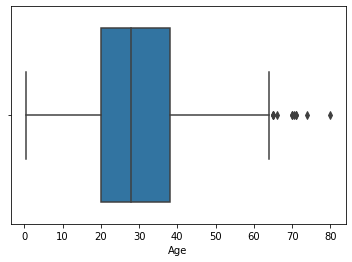

In [79]:
import seaborn as sns
sns.boxplot(df4['Age'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


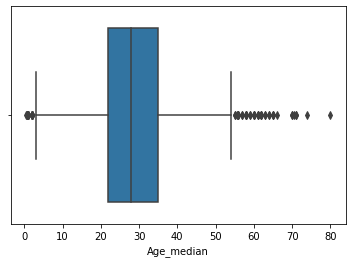

In [80]:
sns.boxplot(df4['Age_median'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


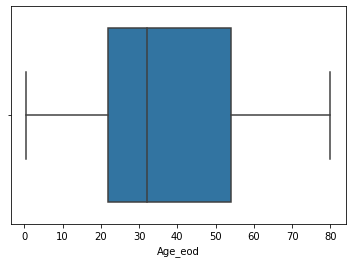

In [81]:
sns.boxplot(df4['Age_eod'])
# Observation
# Outlier problem is solved

#### Arbitrary Value Imputation

In [82]:
df5= pd.read_csv("train.csv", usecols=['Age', "Fare", "Survived"])
df5.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


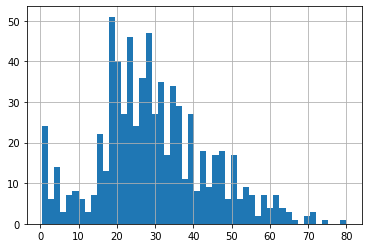

In [85]:
df5["Age"].hist(bins = 50)

In [90]:
def avi_impute(df, variable):
    df[variable+"_zero"] = df[variable].fillna(0)
    df[variable+"_eities"] = df[variable].fillna(80)

In [91]:
avi_impute(df5,'Age')

In [92]:
df5.head()

,Survived,Age,Fare,Age_zero,Age_eities
0,0,22.0,7.2500,22.0,22.0
1,1,38.0,71.2833,38.0,38.0
2,1,26.0,7.9250,26.0,26.0
3,1,35.0,53.1000,35.0,35.0
4,0,35.0,8.0500,35.0,35.0


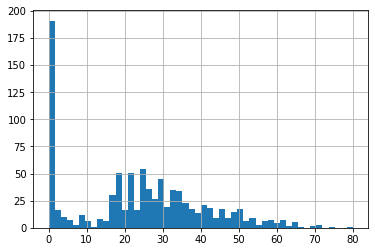

In [94]:
df5["Age_zero"].hist(bins = 50)

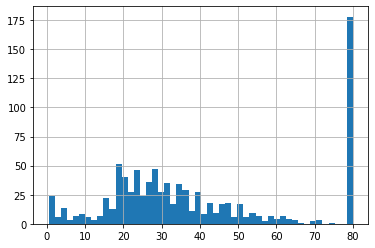

In [95]:
df5["Age_eities"].hist(bins = 50)